In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import divisors
from dataclasses import dataclass
import math
from typing import Callable

In [2]:
class Model:
    def __init__(self, name="None", d_model=3*2**12, d_ff=9*2**12, ff_matrix_count=(1, 1), layers=120, n_experts=1, n_active_experts=1, num_query_heads=128, group_size=1, \
                 weight_precision_bytes=2, activation_precision_bytes=2, d_head=None, vocab_size=0, parallel_attention=False):
        assert num_query_heads % group_size == 0

        # Variables directly set
        self.d_model = d_model
        self.d_ff = d_ff
        self.layers = layers
        self.n_experts = n_experts
        self.n_active_experts = n_active_experts
        self.num_query_heads = num_query_heads
        self.group_size = group_size
        self.weight_precision_bytes = weight_precision_bytes
        self.activation_precision_bytes = activation_precision_bytes
        self.vocab_size = vocab_size
        self.ff_matrix_count = ff_matrix_count
        self.parallel_attention = parallel_attention

        # Derived variables
        self.ff_params_per_layer_per_expert = sum(self.ff_matrix_count) * self.d_model * self.d_ff
        self.sparsity_factor = self.n_experts // self.n_active_experts
        self.total_ff_params = self.layers * self.n_experts * self.ff_params_per_layer_per_expert
        self.num_kv_heads = 2 * self.num_query_heads//self.group_size
        self.d_head = d_head if d_head != None else self.d_model // self.num_query_heads
        self.d_all_attn_heads = (self.num_query_heads + self.num_kv_heads) * self.d_head
        self.attn_params_per_layer = self.d_all_attn_heads * self.d_model + self.d_head*self.num_query_heads*self.d_model

        self.embedding_params = self.vocab_size * self.d_model * 2
        self.total_attn_params = self.layers * self.attn_params_per_layer
        self.total_params = self.total_attn_params + self.total_ff_params + self.embedding_params
        self.total_active_params = self.total_attn_params + self.total_ff_params//self.sparsity_factor + self.embedding_params

        self.kv_cache_size_per_input_bytes = self.num_kv_heads*self.d_head*self.layers*self.activation_precision_bytes

        self.name = name

    def __repr__(self):
        representation = f"""Model Details:
        Name: {self.name}
        d_model: {self.d_model}
        d_ff: {self.d_ff}
        Depth: {self.layers}
        Total FF Params: {self.total_ff_params}
        Total Embedding Params: {self.embedding_params}
        Num Attention Heads: {self.num_query_heads}
        d_head: {self.d_head}
        Group size: {self.group_size}
        Total Attention Params: {self.total_attn_params}
        Total Params: {self.total_params}
        Total Active Params: {self.total_active_params}
        """
        return representation

    def arithmetic_cost_flop(self, input_len, batch_size):
        return (2*self.total_active_params*batch_size + 2*self.d_head*self.num_query_heads*self.layers*input_len*batch_size)

    def memory_reads_writes_bytes(self, input_len, batch_size, N_GPU):
        kv_cache_size_bytes = self.kv_cache_size_per_input_bytes*input_len*batch_size
        used_experts_fraction = (1 - (1 - 1/self.sparsity_factor)**batch_size)
        wp = self.weight_precision_bytes
        ap = self.activation_precision_bytes
        f = np.maximum(1, np.sqrt(N_GPU))

        feedforward_matmul_rw_bytes = used_experts_fraction * self.n_experts * sum(self.ff_matrix_count) * \
                                         (wp*self.d_model*self.d_ff + f*ap*self.d_model*batch_size + f*ap*self.d_ff*batch_size)

        qkv_matmul_rw_bytes = wp*self.d_model*self.d_all_attn_heads + f*ap*(self.d_model*batch_size + f*self.d_all_attn_heads*batch_size)

        proj_matmul_rw_bytes = wp*self.d_head*self.num_query_heads*self.d_model + \
                               ap*(f*self.d_model*batch_size + f*self.d_head*self.num_query_heads*batch_size)

        unembedding_bytes = wp*self.vocab_size*self.d_model

        return kv_cache_size_bytes + self.layers*(feedforward_matmul_rw_bytes + qkv_matmul_rw_bytes + proj_matmul_rw_bytes) + unembedding_bytes

GPT_4 = Model(name="GPT-4",
              d_model=12288,
              d_ff=3*12288,
              layers=120,
              n_experts=16,
              n_active_experts=2,
              num_query_heads=96,
              group_size=96,
              d_head=3*12288//(2*96),
              activation_precision_bytes=2,
              weight_precision_bytes=2,
              vocab_size=100256,
)

GPT_3_5 = Model(name="GPT 3.5",
                d_model=2**9 * 3**2,
                d_ff=4 * 2**9 * 3**2,
                layers=32,
                n_experts=4,
                n_active_experts=2,
                num_query_heads=32,
                group_size=32,
                activation_precision_bytes=2,
                weight_precision_bytes=2
)

GPT_3 = Model(name="GPT-3",
              d_model=12288,
              d_ff=4*12288,
              layers=96,
              n_experts=1,
              n_active_experts=1,
              num_query_heads=96,
              d_head=128,
              activation_precision_bytes=2,
              weight_precision_bytes=2,
              vocab_size=50257
)

PaLM_540B = Model(name="PaLM 540B",
                  d_model=18432,
                  d_ff=73728,
                  ff_matrix_count=(2, 1),
                  layers=118,
                  n_experts=1,
                  n_active_experts=1,
                  num_query_heads=48,
                  d_head=256,
                  group_size=48,
                  activation_precision_bytes=2,
                  weight_precision_bytes=2,
                  vocab_size=256000,
                  parallel_attention=True
)

PaLM_8B = Model(name="PaLM 8B",
                d_model=4096,
                d_ff=4*4096,
                ff_matrix_count=(2, 1),
                layers=32,
                num_query_heads=16,
                group_size=16,
                d_head=256,
                activation_precision_bytes=2,
                weight_precision_bytes=1,
                vocab_size=256000,
                parallel_attention=True
)

Falcon = Model(name="Falcon 180B",
               d_model=14848,
               d_ff=4*14848,
               layers=80,
               d_head=64,
               num_query_heads=232,
               group_size=232,
               activation_precision_bytes=2,
               weight_precision_bytes=2,
               vocab_size=65024
)

GPT_J_6B = Model(name="GPT-J 6B",
                 d_model=4096,
                 d_ff=4*4096,
                 layers=28,
                 num_query_heads=16,
                 d_head=256,
                 group_size=1,
                 activation_precision_bytes=2,
                 weight_precision_bytes=2,
                 vocab_size=50257
)

Mixtral_8x22B = Model(name="Mixtral 8x22B",
                      d_model=6144,
                      d_ff=16384,
                      ff_matrix_count=(2, 1),
                      layers=56,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=48,
                      d_head=128,
                      group_size=6,
                      activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Mixtral_8x7B = Model(name="Mixtral 8x7B",
                      d_model=4096,
                      d_ff=14336,
                      ff_matrix_count=(2, 1),
                      layers=32,
                      n_experts=8,
                      n_active_experts=2,
                      num_query_heads=32,
                      group_size=4,
                     activation_precision_bytes=2,
                      weight_precision_bytes=2,
                      vocab_size=32000
)

Llama_3_8B = Model(name="LLaMa 3 8B",
                    d_model=4096,
                    d_ff=14336,
                    ff_matrix_count=(2, 1),
                    layers=32,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=32,
                    group_size=4,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_8B_8_bit = Model(name="LLaMa 3 8B",
                        d_model=4096,
                        d_ff=14336,
                        ff_matrix_count=(2, 1),
                        layers=32,
                        n_experts=1,
                        n_active_experts=1,
                        num_query_heads=32,
                        group_size=4,
                        activation_precision_bytes=1,
                        weight_precision_bytes=2,
                        vocab_size=128256
)

Llama_3_70B = Model(name="LLaMa 3 70B",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_70B_8_bit = Model(name="LLaMa 3 70B 8-bit",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=1,
                    vocab_size=128256
)

Llama_3_70B_4_bit = Model(name="LLaMa 3 70B 4-bit",
                    d_model=8192,
                    d_ff=28672,
                    ff_matrix_count=(2, 1),
                    layers=80,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=64,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=0.5,
                    vocab_size=128256
)

Llama_3_405B = Model(name="LLaMa 3 405B",
                    d_model=16384,
                    d_ff=53248,
                    ff_matrix_count=(2, 1),
                    layers=126,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=128,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=2,
                    vocab_size=128256
)

Llama_3_405B_8_bit = Model(name="LLaMa 3 405B",
                    d_model=16384,
                    d_ff=53248,
                    ff_matrix_count=(2, 1),
                    layers=126,
                    n_experts=1,
                    n_active_experts=1,
                    num_query_heads=128,
                    group_size=8,
                    activation_precision_bytes=2,
                    weight_precision_bytes=1,
                    vocab_size=128256
)

class GPU:
    name: str
    flop_per_second: float
    hbm_bandwidth_Bps: float
    hbm_size_bytes: float
    l2_bandwidth_Bps: float
    l2_cache_size_bytes: float
    intranode_allreduce_bandwidth_Bps: float
    internode_allreduce_bandwidth_Bps: float
    node_size: int
    price_dollars_per_hour: float
    kernel_launch_latency_seconds: float
    collective_time_seconds: Callable[[float, float, float, 'GPU', str], float]

    def __init__(self,
                 name: str,
                 flop_per_second: float,
                 hbm_bandwidth_Bps: float,
                 hbm_size_bytes: float,
                 l2_bandwidth_Bps: float,
                 l2_cache_size_bytes: float,
                 intranode_allreduce_bandwidth_Bps: float,
                 internode_allreduce_bandwidth_Bps: float,
                 node_size: int,
                 price_dollars_per_hour: float,
                 kernel_launch_latency_seconds: float,
                 collective_time_seconds: Callable[[float, float, float, 'GPU', str], float]):
        self.name = name
        self.flop_per_second = flop_per_second
        self.hbm_bandwidth_Bps = hbm_bandwidth_Bps
        self.hbm_size_bytes = hbm_size_bytes
        self.l2_bandwidth_Bps = l2_bandwidth_Bps
        self.l2_cache_size_bytes = l2_cache_size_bytes
        self.intranode_allreduce_bandwidth_Bps = intranode_allreduce_bandwidth_Bps
        self.internode_allreduce_bandwidth_Bps = internode_allreduce_bandwidth_Bps
        self.node_size = node_size
        self.price_dollars_per_hour = price_dollars_per_hour
        self.kernel_launch_latency_seconds = kernel_launch_latency_seconds
        self.collective_time_seconds = collective_time_seconds

def collective_latency_nccl_seconds(nRanks, nNodes, coll="allreduce", algo="LL"):
   if coll == "allreduce":
     m = 2
   else:
     m = 1

   if algo == "LL":
      return m * ((nRanks/nNodes - 1)*0.6e-6 + 5e-6*np.log2(nNodes)) + 6.8e-6
   elif algo == "LL128":
      return m * ((nRanks/nNodes - 1)*1.25e-6 + 8.5e-6*np.log2(nNodes)) + 14e-6
   elif algo == "Simple":
      return m * ((nRanks/nNodes - 1)*28e-6 + 28e-6*np.log2(nNodes))
   else:
      raise Exception

def mean_collective_time_nccl_seconds(nRanks, nNodes, bytes, gpu: GPU, coll="allreduce"):
    result = np.infty * np.ones(shape=np.shape(nRanks))
    assert nRanks >= nNodes and nNodes >= nRanks/gpu.node_size

    if coll == "allreduce":
        m = 2
    else:
        m = 1

    algorithm_bandwidth_factors = {"Simple": 1,
                                    "LL128": 0.9,
                                    "LL": 0.5}

    if coll == "p2p":
       assert nRanks == 2

    for algo in algorithm_bandwidth_factors:
      bw_factor = algorithm_bandwidth_factors[algo]
      curr_latency_time_seconds = collective_latency_nccl_seconds(nRanks, nNodes, coll=coll, algo=algo)
      curr_bw_time_seconds = m*nNodes*(nRanks/nNodes - 1)*bytes/(nRanks*gpu.intranode_allreduce_bandwidth_Bps*bw_factor) + \
                              m*(nNodes-1)*bytes/(nRanks*gpu.internode_allreduce_bandwidth_Bps*bw_factor)
      
      nonlinear_correction_time_seconds = 500e-6 * (bytes/1e8)**0.4
      result = np.minimum(result, curr_latency_time_seconds + curr_bw_time_seconds + nonlinear_correction_time_seconds)

    result[np.where(nRanks <= 1)] = 0
    return result

def tpu_collective_time_seconds(nRanks, nNodes, bytes, gpu: GPU, coll="allreduce"):
    assert nNodes == 1
    result = np.infty * np.ones(shape=np.shape(nRanks))

    if coll == "allreduce":
        m = 2
    else:
        m = 1

    if coll == "p2p":
        assert nRanks == 2

    curr_latency_time_seconds = m*(nRanks-1)*1e-6
    curr_bw_time_seconds = m*(nRanks-1)*bytes/(nRanks*gpu.internode_allreduce_bandwidth_Bps)

    nonlinear_correction_time_seconds = 500e-6 * (bytes/1e8)**0.4
    result = np.minimum(result, curr_latency_time_seconds + curr_bw_time_seconds + nonlinear_correction_time_seconds)

    result[np.where(nRanks <= 1)] = 0
    return result


H100 = GPU(name="H100",
           flop_per_second={4: 2e15, 8: 2e15, 16: 1e15},
           hbm_bandwidth_Bps=3.3e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7, # count only one partition of L2 to be conservative
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=9e11/4,
           internode_allreduce_bandwidth_Bps=5e10/2,
           node_size=8,
           price_dollars_per_hour=3.15*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds
)

A100 = GPU(name="A100",
           flop_per_second={8: 6.24e14, 16: 3.12e14},
           hbm_bandwidth_Bps=2e12,
           hbm_size_bytes=8e10,
           l2_cache_size_bytes=2.5e7, # count only one partition of L2 to be conservative
           l2_bandwidth_Bps=1.2e13,
           intranode_allreduce_bandwidth_Bps=6e11/4,
           internode_allreduce_bandwidth_Bps=2.5e10/2,
           node_size=8,
           price_dollars_per_hour=2.26*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds
)
V100 = GPU(name="V100",
           flop_per_second={8: 1e14, 16: 1e14},
           hbm_bandwidth_Bps=9e11,
           hbm_size_bytes=1.6e10,
           l2_cache_size_bytes=2.5e7,
           l2_bandwidth_Bps=3e12,
           intranode_allreduce_bandwidth_Bps=3e11/4,
           internode_allreduce_bandwidth_Bps=1.25e10/2,
           node_size=8,
           price_dollars_per_hour=0.63*2/3,
           kernel_launch_latency_seconds=4e-6,
           collective_time_seconds=mean_collective_time_nccl_seconds
)
TPU_v4 = GPU(name="TPU v4",
             flop_per_second={8: 2.6e14, 16: 2.6e14},
             hbm_bandwidth_Bps=1.6e12,
             hbm_size_bytes=32e9,
             l2_cache_size_bytes=5e4,
             l2_bandwidth_Bps=6.44e12,
             intranode_allreduce_bandwidth_Bps=2.5e11,
             internode_allreduce_bandwidth_Bps=2.5e10,
             node_size=4096,
             price_dollars_per_hour=1,
             kernel_launch_latency_seconds=4e-6,
             collective_time_seconds=tpu_collective_time_seconds
)
Groq_LPU = GPU(name="Groq LPU",
               flop_per_second={8: 750e12, 16: 188e12},
               hbm_bandwidth_Bps=8e13,
               hbm_size_bytes=230e6,
               l2_cache_size_bytes=0,
               l2_bandwidth_Bps=np.infty,
               intranode_allreduce_bandwidth_Bps=np.infty,
               internode_allreduce_bandwidth_Bps=330e9/2,
               node_size=1,
               price_dollars_per_hour=1,
               kernel_launch_latency_seconds=4e-6,
               collective_time_seconds=tpu_collective_time_seconds
)

print(Llama_3_70B) # print llama 3 70B as an example

Model Details:
        Name: LLaMa 3 70B
        d_model: 8192
        d_ff: 28672
        Depth: 80
        Total FF Params: 56371445760
        Total Embedding Params: 2101346304
        Num Attention Heads: 64
        d_head: 128
        Group size: 8
        Total Attention Params: 12079595520
        Total Params: 70552387584
        Total Active Params: 70552387584
        


## New latency functions

In [3]:
def section_2_2_token_latency_seconds(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0):
   t_reduce_seconds = 2e-6 * np.maximum(N_GPU**(1/2) - 1, 0) + 6e-6
   t_matmul_seconds = 0

   if model.parallel_attention:
      allreduces_per_layer = 2
   else:
      allreduces_per_layer = 4

   result = model.layers*allreduces_per_layer*t_reduce_seconds + np.maximum(model.weight_precision_bytes*model.total_params/(N_GPU*gpu.hbm_bandwidth_Bps), \
                                                                                    2*model.total_params*batch_size/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))
   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
   result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")

   return result

"""
The token latency function as presented in the paper.
This implementation follows the description in Section 3.5 exactly.
"""
def token_latency_seconds_as_presented_in_paper(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0, seq_len=1):
   serial_matmuls_per_layer = 4
   words_reduced = [model.d_head*(model.num_kv_heads + model.num_query_heads), model.d_model, \
                     model.ff_matrix_count[0]*model.d_ff, model.ff_matrix_count[1]*model.d_model]
   
   nRanks = N_GPU**(1/2)
   nNodes = np.ceil(N_GPU/gpu.node_size)**(1/2)

   arithmetic_cost_flop = model.arithmetic_cost_flop(input_len, batch_size*seq_len)
   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size

   memory_rw_bytes = model.memory_reads_writes_bytes(input_len, batch_size*seq_len, N_GPU)

   network_comm_time_sec = np.zeros(shape=np.shape(N_GPU))

   for words_reduced_sample in words_reduced:
      bytes_reduced = words_reduced_sample * batch_size * seq_len * model.activation_precision_bytes
      network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce")

   result = (model.layers*serial_matmuls_per_layer*gpu.kernel_launch_latency_seconds) + network_comm_time_sec \
            + np.maximum( memory_rw_bytes/(N_GPU*gpu.hbm_bandwidth_Bps), \
                              arithmetic_cost_flop/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))

   kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
   result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")

   return result

"""
This token latency function has some additional capabilities over the one presented in the paper.
It enables turning 2D TP on/off and properly handles pipeline parallelism.
These make a small difference when working with NVIDIA hardware but are important if we want to apply the model to e.g. Groq LPUs.
"""
def final_token_latency_seconds(N_GPU, model: Model, gpu: GPU, batch_size, input_len=0, seq_len=1):
   result = float("inf") * np.ones(shape=np.shape(N_GPU))
   if np.shape(batch_size) != np.shape(N_GPU):
      batch_size = batch_size * np.ones(shape=np.shape(N_GPU))

   for two_d_tensor_parallel in [True, False]:
    for N_PP in divisors(model.layers):
        num_of_microbatches = N_PP
        microbatch_size = batch_size/num_of_microbatches
        N_TP = N_GPU/N_PP

        for interleaving_factor in [1]: # redundant modeling of pipeline interleaving, it's not useful if we always assume no bubbles
          bubble_fraction = 0 # optimistically assume we can ignore pipeline bubbles if we have N_PP microbatches
                              # this is false in practice but easier to implement & faster to run than a function optimizing over microbatch size, interleaving factor, etc.
          # bubble_fraction = (N_PP - 1)/(N_PP - 1 + interleaving_factor*num_of_microbatches)

          serial_matmuls_per_layer = 4

          if two_d_tensor_parallel:
              words_reduced = [model.d_head*(model.num_kv_heads + model.num_query_heads), model.d_model, \
                               model.ff_matrix_count[0]*model.d_ff, model.ff_matrix_count[1]*model.d_model]
              
              nRanks = N_TP**(1/2)
              nNodes = np.ceil(N_TP/gpu.node_size)**(1/2)
          else:
              words_reduced = [model.d_model, model.ff_matrix_count[1]*model.d_model]

              nRanks = N_TP
              nNodes = np.ceil(N_TP/gpu.node_size)

          arithmetic_cost_flop = model.arithmetic_cost_flop(input_len, batch_size*seq_len)
          kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size

          memory_rw_bytes = num_of_microbatches * model.memory_reads_writes_bytes(input_len, microbatch_size*seq_len, N_TP)

          network_comm_time_sec = np.zeros(shape=np.shape(N_GPU))

          for words_reduced_sample in words_reduced:
             bytes_reduced = words_reduced_sample * batch_size * seq_len * model.activation_precision_bytes
             network_comm_time_sec += model.layers * gpu.collective_time_seconds(nRanks, nNodes, bytes_reduced, gpu, "allreduce")

          pp_words_read = model.d_model * batch_size * seq_len
          pp_bytes_read = pp_words_read*model.activation_precision_bytes

          network_comm_time_sec += (N_PP*interleaving_factor - 1) * gpu.collective_time_seconds(2, 2, pp_bytes_read, gpu, "p2p")

          curr_result = (model.layers*serial_matmuls_per_layer*gpu.kernel_launch_latency_seconds) + network_comm_time_sec \
                        + np.maximum( memory_rw_bytes/(N_GPU*gpu.hbm_bandwidth_Bps), \
                                      arithmetic_cost_flop/(N_GPU*gpu.flop_per_second[8*model.weight_precision_bytes]))

          kv_cache_size_bytes = model.kv_cache_size_per_input_bytes * input_len * batch_size
          curr_result[np.where(N_GPU * gpu.hbm_size_bytes < kv_cache_size_bytes + model.weight_precision_bytes*model.total_params)] = float("inf")
          curr_result[np.where(N_PP > np.minimum(N_GPU, batch_size))] = float("inf")

          result = np.minimum(result, curr_result)

   return result

token_latency_seconds_default = token_latency_seconds_as_presented_in_paper
#token_latency_seconds_default = final_token_latency_seconds

def spec_dec_token_latency_seconds(N_GPU, model: Model, approx_model: Model, gpu: GPU, batch_size, acceptance_prob, gamma_max, input_len=0):
   final_latency = token_latency_seconds_default(N_GPU, model, gpu, batch_size, input_len)
   approx_token_latency = token_latency_seconds_default(N_GPU, approx_model, gpu, batch_size, input_len)

   for gamma in range(1, gamma_max+1):
     base_token_latency = token_latency_seconds_default(N_GPU, model, gpu, batch_size, input_len, seq_len=gamma+1)

     total_latency = base_token_latency + approx_token_latency*gamma
     expected_tokens_generated = (1 - acceptance_prob**(gamma+1))/(1 - acceptance_prob)
     final_latency = np.minimum(final_latency, total_latency/expected_tokens_generated)

   return final_latency

In [ ]:
n_gpu_range = np.arange(1, 1024)
model = GPT_4
gpu = H100
input_len = 0

batch_size_list = [d*model.sparsity_factor for d in [32, 64, 128, 256, 512]]

#N_max_EP = model.n_experts
N_max_EP = 1

plt.plot(n_gpu_range, 1/token_latency_seconds_default(n_gpu_range, model=model, gpu=gpu, batch_size=1, input_len=input_len), \
                                                      label="Small batch size limit", color=plt.cm.viridis(0.1))

for batch_size in batch_size_list:
  color = plt.cm.viridis(0.25 + 0.5 * np.log(batch_size/min(batch_size_list))/np.log(max(batch_size_list)/min(batch_size_list)))
  plt.plot(n_gpu_range, 1/token_latency_seconds_default(n_gpu_range, model=model, gpu=gpu, batch_size=batch_size, input_len=input_len), \
                                                      label="%s with batch size %d" % (model.name, batch_size), color=color)

#plt.plot(n_gpu_range, 1/token_latency_seconds(n_gpu_range, N_param=540e9, precision_bytes=2, hbm_bandwidth_Bps=1.6e12, n_layers=118), label="PaLM 540B 16 bit (TPU v4)")
#plt.plot(n_gpu_range, 1/token_latency_seconds(n_gpu_range, N_param=540e9, precision_bytes=1, hbm_bandwidth_Bps=1.6e12, n_layers=118), label="PaLM 540B 8 bit (TPU v4)")

plt.xscale("log")

plt.xlabel("Number of accelerators in instance")
plt.ylabel("Tokens per second per request")
plt.title("Decoding rate at large batch sizes")

plt.gca().set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: '%d' % x))

plt.legend()

plt.savefig("decoding_gpt4_large_batch.pdf")
plt.show()

for batch_size in batch_size_list:
  color = plt.cm.viridis(0.25 + 0.5 * np.log(batch_size/min(batch_size_list))/np.log(max(batch_size_list)/min(batch_size_list)))
  token_latency_seconds_local = token_latency_seconds_default(n_gpu_range, model=model, gpu=gpu, batch_size=batch_size, input_len=input_len)
  arithmetic_time = model.arithmetic_cost_flop(input_len, batch_size)/(gpu.flop_per_second[8*model.weight_precision_bytes] * n_gpu_range)
  utilization_rate = arithmetic_time/token_latency_seconds_local
  plt.plot(n_gpu_range, utilization_rate, label="%s with batch size %d" % (model.name, batch_size), color=color)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of accelerators in instance")
plt.ylabel("Utilization rate")
plt.title("Decoding utilization at large batch sizes")

plt.gca().set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: '%d' % x))

plt.gca().set_yticks([0.5, 0.25, 0.1, 0.05, 0.02, 0.01])
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: '%.2f' % y))

plt.legend()

plt.savefig("decoding_large_batch_utilization.pdf")
plt.show()

In [4]:
@dataclass
class TokenEconSettings:
  name: str
  gpu: GPU
  model: Model
  approx_model: Model
  input_len: int
  max_throughput_tokens_per_second: float
  observed_perf: list[tuple[float]] # list consisting of tuples of the form (tokens/sec/request, price in dollars/million output tokens)
  color: str
  spec_dec: bool
  acceptance_prob: float

  def __init__(self, name, gpu, model, input_len=0, max_throughput_tokens_per_second=np.infty, observed_perf=None, color="", spec_dec=False, approx_model=None, acceptance_prob=1):
    self.name = name
    self.gpu = gpu
    self.model = model
    self.input_len = input_len
    self.max_throughput_tokens_per_second = max_throughput_tokens_per_second
    self.observed_perf = observed_perf
    self.color = color
    self.spec_dec = spec_dec
    self.acceptance_prob = acceptance_prob

    if approx_model != None:
      self.approx_model = approx_model

llama_comparison = [TokenEconSettings(name="Llama 3 70B (1M tok/sec)", gpu=H100, model=Llama_3_70B, input_len=1, max_throughput_tokens_per_second=1e6, color="darkblue"),
                    TokenEconSettings(name="Llama 3 70B (10K tok/sec)", gpu=H100, model=Llama_3_70B, input_len=1, max_throughput_tokens_per_second=1e4, color="blue"),
                    #TokenEconSettings(name="Llama 3 70B 8-bit (1M tok/sec)", gpu=H100, model=Llama_3_70B_8_bit, input_len=1, max_throughput_tokens_per_second=1e6),
                    #TokenEconSettings(name="Llama 3 70B 8-bit (10K tok/sec)", gpu=H100, model=Llama_3_70B_8_bit, input_len=1, max_throughput_tokens_per_second=1e4),
                    TokenEconSettings(name="Llama 3 8B (1M tok/sec)", gpu=H100, model=Llama_3_8B, input_len=1, max_throughput_tokens_per_second=1e6, color="darkred"),
                    TokenEconSettings(name="Llama 3 8B (10K tok/sec)", gpu=H100, model=Llama_3_8B, input_len=1, max_throughput_tokens_per_second=1e4, color="red")]

all_models_comparison = [TokenEconSettings(name="GPT-4 (speculative)", gpu=H100, model=GPT_4, observed_perf=[(21, 37.5)], color="blue"),
                         TokenEconSettings(name="GPT-3", gpu=H100, model=GPT_3, color="orange"),
                         TokenEconSettings(name="Llama 3.1 405B", gpu=H100, model=Llama_3_405B, color="purple"),
                         TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H100, model=Llama_3_70B_8_bit, observed_perf=[(158, 0.9)], color="red"),
                         TokenEconSettings(name="Mixtral 8x22B", gpu=H100, model=Mixtral_8x22B, observed_perf=[(89.25, 1.2)], color="green")
                         #TokenEconSettings(name="Llama 3 8B", gpu=H100, model=Llama_3_8B, observed_perf=[(374, 0.2)], color="black")
                         ]

gpus_comparison = [TokenEconSettings(name="H100", gpu=H100, model=Llama_3_8B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="blue"),
                   TokenEconSettings(name="A100", gpu=A100, model=Llama_3_8B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="green"),
                   TokenEconSettings(name="V100", gpu=V100, model=Llama_3_8B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="red"),
                   TokenEconSettings(name="Groq LPU", gpu=Groq_LPU, model=Llama_3_8B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="purple")]

context_length_comparison = [TokenEconSettings(name="Empty context", gpu=H100, model=Llama_3_70B_8_bit, input_len=0, max_throughput_tokens_per_second=np.infty, color="blue"),
                             TokenEconSettings(name="Context of 1K tokens", gpu=H100, model=Llama_3_70B_8_bit, input_len=1000, max_throughput_tokens_per_second=np.infty, color="green"),
                             TokenEconSettings(name="Context of 10K tokens", gpu=H100, model=Llama_3_70B_8_bit, input_len=10000, max_throughput_tokens_per_second=np.infty, color="red")]

quantization_comparison = [TokenEconSettings(name="Llama 3 70B 16-bit", gpu=H100, model=Llama_3_70B, input_len=0, color="red"),
                           TokenEconSettings(name="Llama 3 70B 8-bit", gpu=H100, model=Llama_3_70B_8_bit, input_len=0, color="green"),
                           TokenEconSettings(name="Llama 3 70B 4-bit", gpu=H100, model=Llama_3_70B_4_bit, input_len=0, color="blue")]

spec_dec_comparison = [TokenEconSettings(name="Llama 3 70B (8B acceptance=0.8)", gpu=H100, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="red"),
                       TokenEconSettings(name="Llama 3 70B (no spec dec)", gpu=H100, model=Llama_3_70B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0, color="gray"),
                       TokenEconSettings(name="Llama 3.1 405B (8B acceptance=0.8)", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_8B, spec_dec=True, acceptance_prob=0.8, color="blue"),
                       TokenEconSettings(name="Llama 3.1 405B (no spec dec)", gpu=H100, model=Llama_3_405B, approx_model=Llama_3_70B, spec_dec=True, acceptance_prob=0, color="black")]


tpu_test = [TokenEconSettings(name="Llama 3.1 405B", gpu=TPU_v4, model=Llama_3_405B, approx_model=Llama_3_70B, spec_dec=True, acceptance_prob=0, color="black")]

def pareto_fronts(comparison_list: list[TokenEconSettings], token_latency_seconds_func):
  token_economics_results = []

  for comparison_setting in comparison_list:
    gpu = comparison_setting.gpu
    model = comparison_setting.model
    input_len = comparison_setting.input_len
    max_throughput_tokens_per_second = comparison_setting.max_throughput_tokens_per_second

    # min_num_of_gpus = np.maximum(1, model.total_params*model.precision_bytes/gpu.hbm_size_bytes)
    min_num_of_gpus = model.total_params*model.weight_precision_bytes/gpu.hbm_size_bytes

    batch_size_range = np.logspace(0, 11 + np.log2(model.sparsity_factor), num=400, base=2)
    n_gpu_range = np.logspace(np.log2(min_num_of_gpus), 14, num=400, base=2)

    batch_size_array = np.transpose(np.tile(batch_size_range, (len(n_gpu_range), 1)))
    n_gpu_array = np.tile(n_gpu_range, (len(batch_size_range), 1))

    assert np.shape(batch_size_array) == np.shape(n_gpu_array)

    if comparison_setting.spec_dec:
      token_latency_seconds_array = spec_dec_token_latency_seconds(n_gpu_array, model=model, approx_model=comparison_setting.approx_model, gpu=gpu, batch_size=batch_size_array, \
                                                               gamma_max=20, acceptance_prob=comparison_setting.acceptance_prob, input_len=input_len)
    else:
      token_latency_seconds_array = token_latency_seconds_func(n_gpu_array, model=model, gpu=gpu, batch_size=batch_size_array, input_len=input_len)

    gpu_seconds_per_token = n_gpu_array * token_latency_seconds_array/batch_size_array

    pareto_front_gpu_seconds_per_token = []
    token_latency_valid = []
    gpu_counts = []
    batch_sizes = []

    token_latency_seconds_range = 1e-3 * np.logspace(-1, 3, base=10, num=600)

    for token_latency_seconds_sample in token_latency_seconds_range:
      indices = np.where((token_latency_seconds_array <= token_latency_seconds_sample) & (batch_size_array/token_latency_seconds_array <= max_throughput_tokens_per_second))
      if len(indices[0]) > 0:
        minimal_cost = np.min(gpu_seconds_per_token[indices])
        token_latency_found = np.min(token_latency_seconds_array[np.where(gpu_seconds_per_token == minimal_cost)])
        found_index = np.argmin(token_latency_seconds_array[np.where(gpu_seconds_per_token == minimal_cost)])

        if token_latency_found not in token_latency_valid:
          pareto_front_gpu_seconds_per_token.append(minimal_cost)
          token_latency_valid.append(token_latency_found)
          gpu_counts.append(n_gpu_array[np.where(gpu_seconds_per_token == minimal_cost)][found_index])
          batch_sizes.append(batch_size_array[np.where(gpu_seconds_per_token == minimal_cost)][found_index])

    token_latency_valid = np.array(token_latency_valid)
    pareto_front_gpu_seconds_per_token = np.array(pareto_front_gpu_seconds_per_token)

    gpu_price_dollars_per_second = gpu.price_dollars_per_hour/3600

    x_coords = 1/token_latency_valid
    y_coords = 1e6*pareto_front_gpu_seconds_per_token*gpu_price_dollars_per_second
    token_economics_results.append((x_coords, y_coords, gpu_counts, batch_sizes))

  return token_economics_results

Maximum throughput for Llama 3 70B (8B acceptance=0.8): 180.76 tokens/second/request (using 7.99 GPUs at a batch size of 1.91)
Maximum throughput for Llama 3 70B (no spec dec): 117.54 tokens/second/request (using 15.89 GPUs at a batch size of 2.07)
Maximum throughput for Llama 3.1 405B (8B acceptance=0.8): 103.92 tokens/second/request (using 39.53 GPUs at a batch size of 1.08)
Maximum throughput for Llama 3.1 405B (no spec dec): 54.48 tokens/second/request (using 63.93 GPUs at a batch size of 3.03)


Preferred throughput for Llama 3 70B (8B acceptance=0.8): 139.67 tokens/second/request at 0.68 USD/million output tokens (using 7.99 GPUs at a batch size of 49.32)
Preferred throughput for Llama 3 70B (no spec dec): 85.24 tokens/second/request at 0.71 USD/million output tokens (using 7.99 GPUs at a batch size of 76.54)
Preferred throughput for Llama 3.1 405B (8B acceptance=0.8): 76.59 tokens/second/request at 8.54 USD/million output tokens (using 15.98 GPUs at a batch size of 14.24)
Prefer

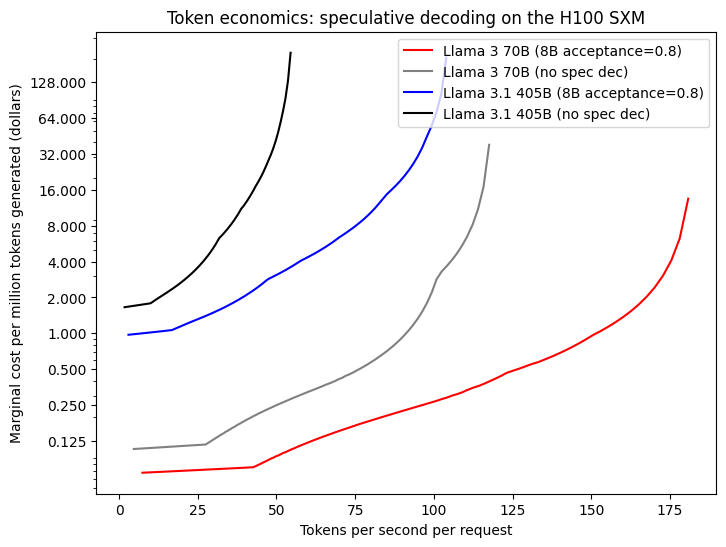

In [5]:
def user_preference_intensity(tokens_per_second_per_request: float, price_per_million_tokens: float):
   return tokens_per_second_per_request**4 / price_per_million_tokens

def preference_maximizing_settings(comparison, token_economics_results):
  results = dict()
  for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes)) in zip(comparison, token_economics_results):
    maximizing_index = np.argmax(user_preference_intensity(x_coords, y_coords))
    results[comparison_setting.name] = {"tokens_per_second_per_request": x_coords[maximizing_index], \
                                        "price_dollars_per_million_tokens": y_coords[maximizing_index], \
                                        "gpus_per_instance": gpu_counts[maximizing_index], \
                                        "batch_size": batch_sizes[maximizing_index]
                                       }
  return results

#token_economics_results = pareto_fronts(llama_comparison, section_2_2_token_latency_seconds)
#current_comparison = gpus_comparison
#current_comparison = all_models_comparison
#current_comparison = context_length_comparison
#current_comparison = llama_comparison
#current_comparison = quantization_comparison
current_comparison = spec_dec_comparison

#current_comparison = tpu_test

token_economics_results = pareto_fronts(current_comparison, token_latency_seconds_default)
#token_economics_results = pareto_fronts(current_comparison, section_2_2_token_latency_seconds)

min_y = min([min(y_coords) for (x_coords, y_coords, gpu_counts, batch_sizes) in token_economics_results])
max_y = max([max(y_coords) for (x_coords, y_coords, gpu_counts, batch_sizes) in token_economics_results])

fig = plt.figure(figsize=(8, 6))

for (comparison_setting, (x_coords, y_coords, gpu_counts, batch_sizes)) in zip(current_comparison, token_economics_results):
  plt.plot(x_coords, y_coords, label=comparison_setting.name, color=comparison_setting.color)
  if comparison_setting.observed_perf != None:
    x_l = []
    y_l = []
    for (x, y) in comparison_setting.observed_perf:
      x_l.append(x)
      y_l.append(y)

    plt.scatter(x_l, y_l, color=comparison_setting.color)

  opt_index = np.argmax(x_coords)
  print("Maximum throughput for %s: %.2f tokens/second/request (using %.2f GPUs at a batch size of %.2f)" % (comparison_setting.name, x_coords[opt_index], \
                                                                                                             gpu_counts[opt_index], batch_sizes[opt_index]))
print("\n")

preference_max_results = preference_maximizing_settings(current_comparison, token_economics_results)
for setting_name in preference_max_results:
  results_dict = preference_max_results[setting_name]
  print("Preferred throughput for %s: %.2f tokens/second/request at %.2f USD/million output tokens (using %.2f GPUs at a batch size of %.2f)" % (setting_name, results_dict["tokens_per_second_per_request"], \
                                                                                                                                                 results_dict["price_dollars_per_million_tokens"], \
                                                                                                                                                 results_dict["gpus_per_instance"], \
                                                                                                                                                 results_dict["batch_size"]))

plt.xlabel("Tokens per second per request")
plt.ylabel("Marginal cost per million tokens generated (dollars)")

plt.yscale("log")
plt.gca().set_yticks([tick for tick in np.logspace(start=-10, stop=10, num=21, base=2) if tick <= max_y and tick >= min_y])
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: '%.3f' % y))

plt.title("Token economics: speculative decoding on the H100 SXM")
plt.legend()

plt.savefig("token_economics_spec_dec_comparison.pdf")
plt.show()

In [ ]:
comp_index = 0
i = np.argmin([abs(x-120) for x in token_economics_results[comp_index][0]])

print("Comparison name", current_comparison[comp_index].name)
print("Tokens per second:", token_economics_results[comp_index][0][i])
print("Dollars per million output tokens:", token_economics_results[comp_index][1][i])
print("Instance size (GPUs):", token_economics_results[comp_index][2][i])
print("Batch size:", token_economics_results[comp_index][3][i])

Comparison name H100
Tokens per second: 119.5522160015801
Dollars per million output tokens: 0.7523234996190256
Instance size (GPUs): 7.900496991959912
Batch size: 51.23997955722834
